In [ ]:
import re

with open("kaijin_nijumenso.txt", mode = "r", encoding = "utf-8") as f:
    text = f.read()
    
text = re.sub("《[^》]+》", "", text)#ルビの削除
text = re.sub("[[^]]+]", "", text)#読みと注意の削除
text = re.sub("[|　 「」\n]", "", text) #|と全角半角スペース、「」と改行の削除
print("文字数",len(text))

文字数 108831


In [ ]:
n_rnn = 10
batch_size = 128
epochs = 30
n_mid = 256

In [ ]:
import numpy as np

chars = sorted(list(set(text)))
print("文字数（重複無し", len(chars))
char_indices = {}
for i,char in enumerate(chars):
    char_indices[char] = i
indices_char = {}
for i, char in enumerate(chars):
    indices_char[i] = char
    
#時系列データと、それから予測すべき文字を取り出します
time_chars = []
next_chars = []
for i in range(0, len(text) - n_rnn):
    time_chars.append(text[i:i+n_rnn])
    next_chars.append(text[i+n_rnn])
    
x = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
t = np.zeros((len(time_chars), len(chars)), dtype=np.bool)
for i, t_cs in enumerate(time_chars):
    t[i, char_indices[next_chars[i]]] = 1
    for j, char in enumerate(t_cs):
        x[i, j, char_indices[char]] = 1
        
print("xの形状", x.shape)
print("tの形状", t.shape)

文字数（重複無し 1249
xの形状 (108821, 10, 1249)
tの形状 (108821, 1249)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
#SimpleRNN層の追加、return_sequenceをTrueにすると、時系列のすべてのRNN層が出力されます。
#return_sequenceをTrueをFalseにすると、最後のRNN層のみが出力を返す。
model.add(LSTM(n_mid, input_shape=(n_rnn, len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer = "adam")
print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               1542144   
_________________________________________________________________
dense_1 (Dense)              (None, 1249)              320993    
Total params: 1,863,137
Trainable params: 1,863,137
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.callbacks import LambdaCallback

def on_epoch_end(epoch, logs):
    print("エポック：", epoch)
    
    beta = 5
    prev_text = text[15:15+n_rnn]
    created_text = prev_text
    
    print("シード：", created_text)
    
    for i in range(400):
        x_pred = np.zeros((1, n_rnn, len(chars)))
    
        for j, char in enumerate(prev_text):
            x_pred[0, j, char_indices[char]] =1
        
        y = model.predict(x_pred)
        p_power = y[0] ** beta
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))
        next_char = indices_char[next_index]
    
        created_text += next_char
        prev_text = prev_text[1:] + next_char
    
    print(created_text)
    print()
    
epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
history_lstm = model.fit(x, t,
                   batch_size=batch_size,
                   epochs=epochs,
                   callbacks=[epoch_end_callback])


Epoch 1/30
108821/108821 [==============================] - 140s 1ms/step - loss: 4.6730
エポック： 0
シード： しがきそのころ、東京
しがきそのころ、東京のです。そのです。、そのには、そのです。、そのに、をのは、面のには、そののは、そのものです。そのです。そのです。そうに、そのには、そのは、そのです。そのです。、そのは、そのです。、そのは、それに、そのは、そのです。そのです。そのです。そのです。そのは、こと、そのです。そのです。そのです。そうに、そのです。そのは、そのに、に、は、をは、いのです。です。そのです。そのです。です。そのは、そのに、そのに、そのです。そのです。です。そうと、そのです。、そのです。そのです。そのは、そのです。、そのには、そのは、そのです。そのです。そのです。、あのは、そのは、そのをは、いのです。、このには、そのです。、つは、、面相のです。そのは、そのです。そのです。そのです。そのです。そのは、そののをは、そのと、そのは、そのです。そのです。そのです。そのは、そのに、そのに、そのには、そのです。そのです。そうに、そのに

Epoch 2/30
108821/108821 [==============================] - 144s 1ms/step - loss: 3.9862
エポック： 1
シード： しがきそのころ、東京
しがきそのころ、東京のです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。そのです。それに、そのです。そのです。そのです。そのです。そのです。そのです。そうに、そのです。そのです。そのです。そのです。そのです。そのです。そうに、そのです。そのです。そのです。そのです。そのです。そのです。それが、そのです。そのです。そのです。そのです。そのです。そのです。そのです。ありません。そのです。そのです。そのです。そのです。そのです。そのです。そのです。

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU

model = Sequential()
#SimpleRNN層の追加、return_sequenceをTrueにすると、時系列のすべてのRNN層が出力されます。
#return_sequenceをTrueをFalseにすると、最後のRNN層のみが出力を返す。
model.add(GRU(n_mid, input_shape=(n_rnn, len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer = "adam")
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 256)               1156608   
_________________________________________________________________
dense_2 (Dense)              (None, 1249)              320993    
Total params: 1,477,601
Trainable params: 1,477,601
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.callbacks import LambdaCallback

def on_epoch_end(epoch, logs):
    print("エポック：", epoch)
    
    beta = 5
    prev_text = text[15:15+n_rnn]
    created_text = prev_text
    
    print("シード：", created_text)
    
    for i in range(400):
        x_pred = np.zeros((1, n_rnn, len(chars)))
    
        for j, char in enumerate(prev_text):
            x_pred[0, j, char_indices[char]] =1
        
        y = model.predict(x_pred)
        p_power = y[0] ** beta
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))
        next_char = indices_char[next_index]
    
        created_text += next_char
        prev_text = prev_text[1:] + next_char
    
    print(created_text)
    print()
    
epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
history_gru = model.fit(x, t,
                   batch_size=batch_size,
                   epochs=epochs,
                   callbacks=[epoch_end_callback])

Epoch 1/30
108821/108821 [==============================] - 157s 1ms/step - loss: 4.5561
エポック： 0
シード： しがきそのころ、東京
しがきそのころ、東京には、このです。そうに、そのです。そのです。そのです。それは、そのです。そのです。そのです。そうは、そのです。そのです。そうは、このです。そうに、そのです。それは、そうに、そのです。そのです。そうは、そのです。そのです。そうは、そのです。そのです。それは、そのです。そのです。そのです。………。…………。、二十面相は、このです。そのです。それは、そのです。そのです。そのです。そうは、そのです。そのです。そうは、そうに、そのです。そのです。そうは、そのです。そのです。そのです。そうは、そのです。そのです。そのです。そうに、そのです。そのです。明智は、そのです。そのです。そのです。それは、そのです。そのです。そうは、そのです。そのです。そのです。それ、そのです。そのです。そのです。そうは、そのです。そのです。そのです。それは、そのです。そうは、そのです。そのです。そのです。それは、そのです。その

Epoch 2/30
108821/108821 [==============================] - 154s 1ms/step - loss: 3.5988
エポック： 1
シード： しがきそのころ、東京
しがきそのころ、東京ッというのです。それは、そのです。それは、そのです。それは、そのです。それは、それは、その中に、その中に、そのほどのです。それに、それにおそれて、その中に、そのです。それは、そのです。それは、そのです。それは、それは、その中に、そのなくのです。それは、ことりの中に、あったのです。それは、そのです。それは、そのです。それに、そうないに、その中に、そうしているのです。それは、それは、そのです。それは、そのです。それは、それに、そのです。それは、それは、そのです。それは、それは、それにおというのです。それは、その中に、それに、そのです。それに、それは、そのです。それは、あるのです。それに、そのです。それは、そのです。それが、あったのです。それは、それには、そのです。それは、それは、その中に、そうにも、

108821/108821 [==============================] - 214s 2ms/step - loss: 1.2350
エポック： 16
シード： しがきそのころ、東京
しがきそのころ、東京中の町という町、家という家では、四ほうからそうです。それから、こんなところへ行って、明智の野郎を喜びさんたちは、あの家へは、どこから魔法使いはないのです。それから、ここにはじゃありませんか。そうですか。明智はすぐに、みごとによっていて、その中に、みんなに手をにぎっていたのです。そのいっぽう、明智探偵に面会しましょう。たしかいうえに心のここまで来たような感じがして、ただまりことなわせるはずはありません。ぼくは少し早くよ。ぼくのほうで、きみをとりこにしたって、おそれたかと思って、二十面相の部下から、うちがいのように口をおりて、うのさわぎにしまったんです。そして、それを聞くと、館長やまだ、一同がいかなければなりません。それにしても、今にも、大きなさい向ちってを見ばやったときでした。彼は電燈を地面におくと、いきなり鉄のとびらがガラガラとしまって、またひとりごとの壮二君が、そのじつのここには、おそろ

Epoch 18/30
108821/108821 [==============================] - 226s 2ms/step - loss: 1.1386
エポック： 17
シード： しがきそのころ、東京
しがきそのころ、東京中の町という町、家という家の建物が、立ちあろうとしています。そのとえ、きみは、なんだか涙が見えます。それが、まるでまきれをいたくていたようです。ね。いつかまにかわられているから、そのまま、にぎりこぶしをかためて、もうとうえました。ああ、読者諸君、これが何をつくっているのですが、しかけては、どんなことをおうとしていたから、そのいっぽうの下男は、こちらしく手紙をことめたれば、しのぼう大事件がてみきましない。ただかり、ふたりの目ばからにこったのでしょう。あれはじゃ、今、ぼくの身辺に、花壇がまんどんなど、賊の手がだったように、おとなさいをいって、きみをとらえるふんなりなとおりますと、ただえの時計を持っているのです。そのほから、かまっているからいいながら、それがでもると、賊はその中へひとこわかり、一同に見つわがられました

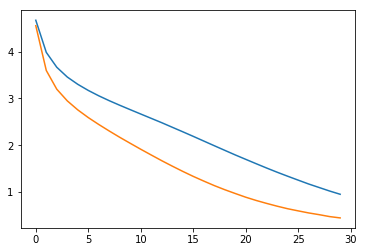

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

loss_lstm = history_lstm.history['loss']
loss_gru = history_gru.history['loss']

plt.plot(np.arange(len(loss_lstm)), loss_lstm, label = "LSTM")
plt.plot(np.arange(len(loss_gru)), loss_gru, label = "GRU")
plt.show()

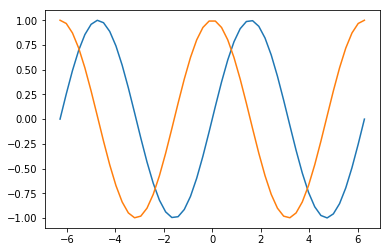

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

axis_x = np.linspace(-2*np.pi, 2*np.pi)
sin_data = np.sin(axis_x)
cos_data = np.cos(axis_x)

plt.plot(axis_x, sin_data)
plt.plot(axis_x, cos_data)
plt.show()

n_rnn = 10
n_sample = len(axis_x)-n_rnn
x_encoder = np.zeros((n_sample, n_rnn))
x_decoder = np.zeros((n_sample, n_rnn))
t_decoder = np.zeros((n_sample, n_rnn))

for i in range(0, n_sample):
    x_encoder[i] = sin_data[i:i+n_rnn]
    x_decoder[i,1:] = cos_data[i:i+n_rnn-1] #一つ後の時刻にずらす。最初の値は0のまま
    t_decoder[i] = cos_data[i:i+n_rnn]#正解は、cos関数の値をそのまま入れる。
    
x_encoder = x_encoder.reshape(n_sample, n_rnn, 1)
x_decoder = x_decoder.reshape(n_sample, n_rnn, 1)
t_decoder = t_decoder.reshape(n_sample, n_rnn, 1)

In [ ]:
from keras.models import Model
from keras.layers import Dense, LSTM, Input

n_in = 1
n_mid = 20
n_out = n_in

encoder_input = Input(shape=(n_rnn, n_in))
encoder_lstm = LSTM(n_mid, return_state=True)
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_input)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = Input(shape=(n_rnn, n_in))
decoder_lstm = LSTM(n_mid, return_sequences = True, return_state=True)
decoder_output, _,_ = decoder_lstm(decoder_input, initial_state=encoder_state)
decoder_dense = Dense(n_out, activation='linear')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(loss="mean_squared_error", optimizer = "adam")
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 20), (None,  1760        input_5[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 10, 20), (No 1760        input_6[0][0]                    
                                                                 lstm_6[0][1]               

In [ ]:
history = model.fit([x_encoder, x_decoder], t_decoder,
                   batch_size = 8,
                   epochs = 30)

Epoch 1/30
40/40 [==============================] - 17s 414ms/step - loss: 0.4493
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 0.410 - 0s 12ms/step - loss: 0.4089
Epoch 3/30
40/40 [==============================] - 0s 11ms/step - loss: 0.3757
Epoch 4/30
40/40 [==============================] - 0s 11ms/step - loss: 0.3450
Epoch 5/30
40/40 [==============================] - 0s 11ms/step - loss: 0.3210
Epoch 6/30
40/40 [==============================] - 0s 10ms/step - loss: 0.2981
Epoch 7/30
40/40 [==============================] - 0s 9ms/step - loss: 0.2783
Epoch 8/30
40/40 [==============================] - 0s 10ms/step - loss: 0.2586
Epoch 9/30
40/40 [==============================] - 0s 12ms/step - loss: 0.2383
Epoch 10/30
40/40 [==============================] - 0s 9ms/step - loss: 0.2157
Epoch 11/30
40/40 [==============================] - 0s 8ms/step - loss: 0.1919
Epoch 12/30
40/40 [==============================] - 0s 9ms/step - loss: 0.1628
Epoch 13/30
40/

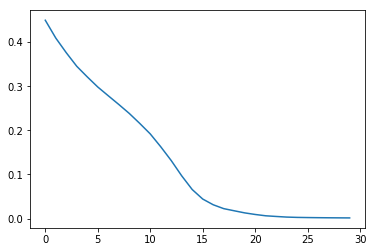

In [ ]:
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

In [ ]:
#encoderのモデルを構築
encoder_model = Model(encoder_input, encoder_state)

#decoderのモデルを構築
decoder_input = Input(shape=(1, n_in))

decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in_c = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h, decoder_state_in_c]

decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_input,
                                                               initial_state=decoder_state_in)
decoder_state = [decoder_state_h, decoder_state_c]

decoder_output = decoder_dense(decoder_output)
decoder_model = Model([decoder_input] + decoder_state_in, [decoder_output] + decoder_state)

In [ ]:
def translate(input_data):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, 1))
    translated = []
    
    for i in range(0, n_rnn):
        y, h, c = decoder_model.predict([y_decoder] + state_value)
        y = y[0][0][0]
        translated.append(y)
        y_decoder[0][0][0] = y
        state_value = [h, c]
    
    return translated

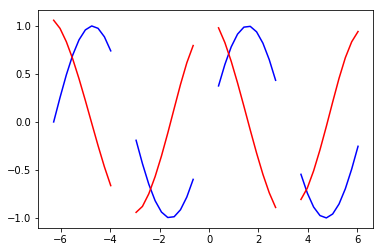

In [ ]:
demo_indices = [0, 13, 26, 39]
for i in demo_indices:
    x_demo = x_encoder[i:i+1]
    y_demo = translate(x_demo)
    
    plt.plot(axis_x[i:i+n_rnn], x_demo.reshape(-1), color = "b")
    plt.plot(axis_x[i:i+n_rnn], y_demo, color = "r")

plt.show()

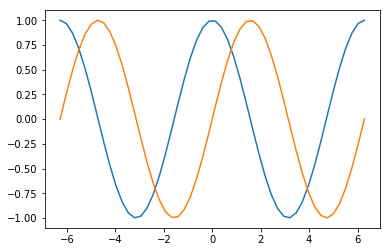

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

axis_x = np.linspace(-2*np.pi, 2*np.pi)
cos_data = np.cos(axis_x)
sin_data = np.sin(axis_x)

plt.plot(axis_x, cos_data)
plt.plot(axis_x, sin_data)
plt.show()

n_rnn = 10
n_sample = len(axis_x)-n_rnn
x_encoder = np.zeros((n_sample, n_rnn))
x_decoder = np.zeros((n_sample, n_rnn))
t_decoder = np.zeros((n_sample, n_rnn))

for i in range(0, n_sample):
    x_encoder[i] = cos_data[i:i+n_rnn]
    x_decoder[i,1:] = sin_data[i:i+n_rnn-1] #一つ後の時刻にずらす。最初の値は0のまま
    t_decoder[i] = sin_data[i:i+n_rnn]#正解は、cos関数の値をそのまま入れる。
    
x_encoder = x_encoder.reshape(n_sample, n_rnn, 1)
x_decoder = x_decoder.reshape(n_sample, n_rnn, 1)
t_decoder = t_decoder.reshape(n_sample, n_rnn, 1)

In [ ]:
from keras.models import Model
from keras.layers import Dense, LSTM, Input

n_in = 1
n_mid = 20
n_out = n_in

encoder_input = Input(shape=(n_rnn, n_in))
encoder_lstm = LSTM(n_mid, return_state=True)
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_input)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = Input(shape=(n_rnn, n_in))
decoder_lstm = LSTM(n_mid, return_sequences = True, return_state=True)
decoder_output, _,_ = decoder_lstm(decoder_input, initial_state=encoder_state)
decoder_dense = Dense(n_out, activation='linear')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(loss="mean_squared_error", optimizer = "adam")
print(model.summary())

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 20), (None,  1760        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 10, 20), (No 1760        input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [ ]:
history = model.fit([x_encoder, x_decoder], t_decoder,
                   batch_size = 8,
                   epochs = 30)


Epoch 1/30
40/40 [==============================] - 2s 51ms/step - loss: 0.5745
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 0.5252
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 0.4821
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 0.4427
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 0.4064
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 0.3731
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 0.3421
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 0.3103
Epoch 9/30
40/40 [==============================] - 0s 2ms/step - loss: 0.2775
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 0.2443
Epoch 11/30
40/40 [==============================] - 0s 2ms/step - loss: 0.2068
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 0.1650
Epoch 13/30
40/40 [============================

In [ ]:
#encoderのモデルを構築
encoder_model = Model(encoder_input, encoder_state)

#decoderのモデルを構築
decoder_input = Input(shape=(1, n_in))

decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in_c = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h, decoder_state_in_c]

decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_input,
                                                               initial_state=decoder_state_in)
decoder_state = [decoder_state_h, decoder_state_c]

decoder_output = decoder_dense(decoder_output)
decoder_model = Model([decoder_input] + decoder_state_in, [decoder_output] + decoder_state)

In [ ]:
def translate(input_data):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, 1))
    translated = []
    
    for i in range(0, n_rnn):
        y, h, c = decoder_model.predict([y_decoder] + state_value)
        y = y[0][0][0]
        translated.append(y)
        y_decoder[0][0][0] = y
        state_value = [h, c]
    
    return translated

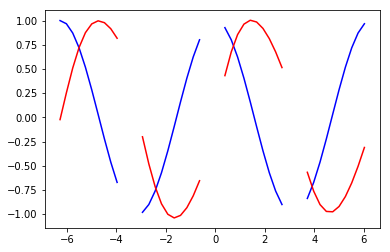

In [ ]:
demo_indices = [0, 13, 26, 39]
for i in demo_indices:
    x_demo = x_encoder[i:i+1]
    y_demo = translate(x_demo)
    
    plt.plot(axis_x[i:i+n_rnn], x_demo.reshape(-1), color = "b")
    plt.plot(axis_x[i:i+n_rnn], y_demo, color = "r")

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re

novels = ["gingatetsudono_yoru.txt", "serohikino_goshu.txt", "chumonno_oi_ryoriten.txt","gusukobudorino_denki.txt",
         "kaeruno_gomugutsu.txt", "kaino_hi.txt", "kashiwabayashino_yoru.txt", "kazeno_matasaburo.txt",
         "kiirono_tomato.txt", "oinomorito_zarumori.txt"]

text = ""
for novel in novels:
    with open('/'+novel, mode = "r", encoding="utf-8") as f:
        text_novel = f.read()
    
    text_novel = re.sub("《[^》]+》", "", text_novel) #ルビの削除
    text_novel = re.sub("［[^］]+］", "", text_novel) #読みの注意の削除
    text_novel = re.sub("〔[^〕]+〕", "", text_novel) #読みの注意の削除
    text_novel = re.sub("[　 \n「」『』（）｜※＊…]", "", text_novel)#全角半角スペース、改行、その他記号の削除
    text += text_novel

print("文字数：", len(text))
print(text)

文字数： 154382
一午後の授業ではみなさんは、そういうふうに川だと言われたり、乳の流れたあとだと言われたりしていた、このぼんやりと白いものがほんとうは何かご承知ですか先生は、黒板につるした大きな黒い星座の図の、上から下へ白くけぶった銀河帯のようなところを指しながら、みんなに問いをかけました。カムパネルラが手をあげました。それから四、五人手をあげました。ジョバンニも手をあげようとして、急いでそのままやめました。たしかにあれがみんな星だと、いつか雑誌で読んだのでしたが、このごろはジョバンニはまるで毎日教室でもねむく、本を読むひまも読む本もないので、なんだかどんなこともよくわからないという気持ちがするのでした。ところが先生は早くもそれを見つけたのでした。ジョバンニさん。あなたはわかっているのでしょうジョバンニは勢いよく立ちあがりましたが、立ってみるともうはっきりとそれを答えることができないのでした。ザネリが前の席からふりかえって、ジョバンニを見てくすっとわらいました。ジョバンニはもうどぎまぎしてまっ赤になってしまいました。先生がまた言いました。大きな望遠鏡で銀河をよっく調べると銀河はだいたい何でしょうやっぱり星だとジョバンニは思いましたが、こんどもすぐに答えることができませんでした。先生はしばらく困ったようすでしたが、眼をカムパネルラの方へ向けて、ではカムパネルラさんと名指しました。するとあんなに元気に手をあげたカムパネルラが、やはりもじもじ立ち上がったままやはり答えができませんでした。先生は意外なようにしばらくじっとカムパネルラを見ていましたが、急いで、では、よしと言いながら、自分で星図を指しました。このぼんやりと白い銀河を大きないい望遠鏡で見ますと、もうたくさんの小さな星に見えるのです。ジョバンニさんそうでしょうジョバンニはまっ赤になってうなずきました。けれどもいつかジョバンニの眼のなかには涙がいっぱいになりました。そうだ僕は知っていたのだ、もちろんカムパネルラも知っている、それはいつかカムパネルラのお父さんの博士のうちでカムパネルラといっしょに読んだ雑誌のなかにあったのだ。それどこでなくカムパネルラは、その雑誌を読むと、すぐお父さんの書斎から巨きな本をもってきて、ぎんがというところをひろげ、まっ黒な頁いっぱいに白に点々のある美しい写真を二人でいつまでも見たので

In [ ]:
! pip install pykakasi 
from pykakasi import kakasi

separator = "。"
sentence_list = text.split(separator)
sentence_list.pop()
sentence_list = [x+separator for x in sentence_list]

kakasi = kakasi()
kakasi.setMode("J", "H")
conv = kakasi.getConverter()
for sentence in sentence_list:
    print(sentence)
    print(conv.do(sentence))
    print()

In [ ]:
kana_text = conv.do(text)
print(set(kana_text))

{'に', 'ぷ', 'ら', 'ラ', 'う', 'ま', 'ガ', 'ろ', 'ぜ', 'べ', 'N', 'テ', 'ぐ', 'ポ', 'ば', 'タ', 'セ', 'き', 'O', 'ベ', 'じ', '、', 'ブ', 'E', 'マ', 'デ', 'ピ', 'レ', 'R', 'と', 'ご', 'ぁ', 'し', 'モ', 'を', 'ハ', 'ホ', 'ロ', 'え', 'そ', 'ぽ', 'ね', 'ふ', 'づ', 'メ', 'ズ', 'ぴ', 'ゆ', 'ン', 'び', 'や', 'わ', 'へ', 'W', 'ニ', 'ビ', 'れ', 'キ', 'ケ', 'U', 'ダ', 'C', 'る', 'オ', '苹', 'A', 'ゎ', 'ペ', 'エ', 'ぎ', 'て', 'く', 'あ', 'S', 'D', 'カ', 'グ', 'H', 'よ', 'ヤ', 'ェ', 'ト', 'ょ', 'ィ', 'I', 'ぱ', 'ん', 'た', '〇', 'ミ', 'ヘ', 'ァ', 'ゅ', 'ひ', 'せ', 'ぇ', 'リ', 'み', 'ず', 'ぞ', 'ノ', 'の', 'サ', 'ナ', 'い', '！', 'ざ', 'ぬ', 'め', 'ワ', 'か', 'は', 'む', 'が', 'ぼ', 'イ', 'プ', 'L', 'ヴ', 'ウ', 'T', 'ゴ', 'コ', 'ネ', 'ォ', 'ど', 'つ', 'フ', 'こ', 'っ', 'ぢ', 'ぶ', 'ツ', 'ほ', 'ち', '？', 'シ', 'ド', 'さ', 'ゃ', 'パ', 'ザ', 'ジ', 'お', 'ギ', 'ュ', 'で', 'だ', 'ー', 'け', 'ぺ', 'ソ', 'ボ', 'ョ', 'す', 'げ', 'も', 'り', '。', 'ル', 'ア', 'ャ', 'ク', 'ッ', 'ム', 'チ', 'バ', 'ス', 'な', 'ヒ'}


In [ ]:
print(kana_text)
with open("kana_kanji.txt", mode="w", encoding="utf-8") as f:
    f.write(kana_text)

いちごごのじゅぎょうではみなさんは、そういうふうにかわだといわれたり、ちちのながれたあとだといわれたりしていた、このぼんやりとしろいものがほんとうはなにかごしょうちですかせんせいは、こくばんにつるしたおおきなくろいせいざのずの、うえからしたへしろくけぶったぎんがおびのようなところをさしながら、みんなにといをかけました。カムパネルラがてをあげました。それからし、ごにんてをあげました。ジョバンニもてをあげようとして、いそいでそのままやめました。たしかにあれがみんなほしだと、いつかざっしでよんだのでしたが、このごろはジョバンニはまるでまいにちきょうしつでもねむく、ほんをよむひまもよむほんもないので、なんだかどんなこともよくわからないというきもちがするのでした。ところがせんせいははやくもそれをみつけたのでした。ジョバンニさん。あなたはわかっているのでしょうジョバンニはいきおいよくたちあがりましたが、たってみるともうはっきりとそれをこたえることができないのでした。ザネリがまえのせきからふりかえって、ジョバンニをみてくすっとわらいました。ジョバンニはもうどぎまぎしてまっあかになってしまいました。せんせいがまたいいました。おおきなぼうえんきょうでぎんがをよっくしらべるとぎんがはだいたいなんでしょうやっぱりほしだとジョバンニはおもいましたが、こんどもすぐにこたえることができませんでした。せんせいはしばらくこまったようすでしたが、めをカムパネルラのほうへむけて、ではカムパネルラさんとなざしました。するとあんなにげんきにてをあげたカムパネルラが、やはりもじもじたちあがったままやはりこたえができませんでした。せんせいはいがいなようにしばらくじっとカムパネルラをみていましたが、いそいで、では、よしといいながら、じぶんでせいずをさしました。このぼんやりとしろいぎんがをおおきないいぼうえんきょうでみますと、もうたくさんのちいさなほしにみえるのです。ジョバンニさんそうでしょうジョバンニはまっあかになってうなずきました。けれどもいつかジョバンニのめのなかにはなみだがいっぱいになりました。そうだぼくはしっていたのだ、もちろんカムパネルラもしっている、それはいつかカムパネルラのおとうさんのはかせのうちでカムパネルラといっしょによんだざっしのなかにあったのだ。それどこでなくカムパネルラは、そのざっしをよ

In [ ]:
with open("kana_kanji.txt", mode="r", encoding="utf-8") as f:
    kana_text = f.read()
print(kana_text)

いちごごのじゅぎょうではみなさんは、そういうふうにかわだといわれたり、ちちのながれたあとだといわれたりしていた、このぼんやりとしろいものがほんとうはなにかごしょうちですかせんせいは、こくばんにつるしたおおきなくろいせいざのずの、うえからしたへしろくけぶったぎんがおびのようなところをさしながら、みんなにといをかけました。カムパネルラがてをあげました。それからし、ごにんてをあげました。ジョバンニもてをあげようとして、いそいでそのままやめました。たしかにあれがみんなほしだと、いつかざっしでよんだのでしたが、このごろはジョバンニはまるでまいにちきょうしつでもねむく、ほんをよむひまもよむほんもないので、なんだかどんなこともよくわからないというきもちがするのでした。ところがせんせいははやくもそれをみつけたのでした。ジョバンニさん。あなたはわかっているのでしょうジョバンニはいきおいよくたちあがりましたが、たってみるともうはっきりとそれをこたえることができないのでした。ザネリがまえのせきからふりかえって、ジョバンニをみてくすっとわらいました。ジョバンニはもうどぎまぎしてまっあかになってしまいました。せんせいがまたいいました。おおきなぼうえんきょうでぎんがをよっくしらべるとぎんがはだいたいなんでしょうやっぱりほしだとジョバンニはおもいましたが、こんどもすぐにこたえることができませんでした。せんせいはしばらくこまったようすでしたが、めをカムパネルラのほうへむけて、ではカムパネルラさんとなざしました。するとあんなにげんきにてをあげたカムパネルラが、やはりもじもじたちあがったままやはりこたえができませんでした。せんせいはいがいなようにしばらくじっとカムパネルラをみていましたが、いそいで、では、よしといいながら、じぶんでせいずをさしました。このぼんやりとしろいぎんがをおおきないいぼうえんきょうでみますと、もうたくさんのちいさなほしにみえるのです。ジョバンニさんそうでしょうジョバンニはまっあかになってうなずきました。けれどもいつかジョバンニのめのなかにはなみだがいっぱいになりました。そうだぼくはしっていたのだ、もちろんカムパネルラもしっている、それはいつかカムパネルラのおとうさんのはかせのうちでカムパネルラといっしょによんだざっしのなかにあったのだ。それどこでなくカムパネルラは、そのざっしをよ

In [ ]:
import pickle

hiragana = "ぁあぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞただちぢつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽ\
まみむめもゃやゅゆょよらりるれろゎわゐゑをん"

katakana = "ァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポ\
マミムメモャヤュユョヨラリルレロヮワヰヱヲンヴ"

chars = hiragana + katakana

with open("kana_kanji.txt", mode="r", encoding="utf-8") as f:
    text = f.read()

for char in text:
    if char not in chars:
        chars += char

chars += "\t\n"

chars_list = sorted(list(chars))
print(chars_list)

with open("kana_chars.pickle", mode="wb") as f:
    pickle.dump(chars_list, f)

['\t', '\n', 'A', 'C', 'D', 'E', 'H', 'I', 'L', 'N', 'O', 'R', 'S', 'T', 'U', 'W', '、', '。', '〇', 'ぁ', 'あ', 'ぃ', 'い', 'ぅ', 'う', 'ぇ', 'え', 'ぉ', 'お', 'か', 'が', 'き', 'ぎ', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'さ', 'ざ', 'し', 'じ', 'す', 'ず', 'せ', 'ぜ', 'そ', 'ぞ', 'た', 'だ', 'ち', 'ぢ', 'っ', 'つ', 'づ', 'て', 'で', 'と', 'ど', 'な', 'に', 'ぬ', 'ね', 'の', 'は', 'ば', 'ぱ', 'ひ', 'び', 'ぴ', 'ふ', 'ぶ', 'ぷ', 'へ', 'べ', 'ぺ', 'ほ', 'ぼ', 'ぽ', 'ま', 'み', 'む', 'め', 'も', 'ゃ', 'や', 'ゅ', 'ゆ', 'ょ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'ゎ', 'わ', 'ゐ', 'ゑ', 'を', 'ん', 'ァ', 'ア', 'ィ', 'イ', 'ゥ', 'ウ', 'ェ', 'エ', 'ォ', 'オ', 'カ', 'ガ', 'キ', 'ギ', 'ク', 'グ', 'ケ', 'ゲ', 'コ', 'ゴ', 'サ', 'ザ', 'シ', 'ジ', 'ス', 'ズ', 'セ', 'ゼ', 'ソ', 'ゾ', 'タ', 'ダ', 'チ', 'ヂ', 'ッ', 'ツ', 'ヅ', 'テ', 'デ', 'ト', 'ド', 'ナ', 'ニ', 'ヌ', 'ネ', 'ノ', 'ハ', 'バ', 'パ', 'ヒ', 'ビ', 'ピ', 'フ', 'ブ', 'プ', 'ヘ', 'ベ', 'ペ', 'ホ', 'ボ', 'ポ', 'マ', 'ミ', 'ム', 'メ', 'モ', 'ャ', 'ヤ', 'ュ', 'ユ', 'ョ', 'ヨ', 'ラ', 'リ', 'ル', 'レ', 'ロ', 'ヮ', 'ワ', 'ヰ', 'ヱ', 'ヲ', 'ン', 'ヴ', 'ー', '苹', '！', '？']


In [ ]:
import numpy as np

char_indices = {} #文字がキーでインデックスが値
for i, char in enumerate(chars_list):
    char_indices[char] = i
indices_char = {} #インデックスがキーで文字が値
for i, char in enumerate(chars_list):
    indices_char[i] = char
    
seperator = "。"
sentence_list = text.split(seperator)
sentence_list.pop()
sentence_list = [x+seperator for x in sentence_list]

max_sentence_length = 128 #これより長い文章はカット
sentence_list = [sentence for sentence in sentence_list if len(sentence) <= max_sentence_length]

n_char = len(chars_list)
n_sample = len(sentence_list) - 1

x_sentences = []
t_sentences = []
for i in range(n_sample):
    x_sentences.append(sentence_list[i])
    t_sentences.append("\t" + sentence_list[i+1] + "\n")
    
max_length_x = max_sentence_length
max_length_t = max_sentence_length + 2

x_encoder = np.zeros((n_sample, max_length_x, n_char), dtype=np.bool)
x_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)
t_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)

for i in range(n_sample):
    x_sentence = x_sentences[i]
    t_sentence = t_sentences[i]
    for j, char in enumerate(x_sentence):
        x_encoder[i, j, char_indices[char]] = 1
    for j, char in enumerate(t_sentence):
        x_decoder[i, j, char_indices[char]] = 1
        if j > 0:#正解は入力より1つ前の時刻のものにする
            t_decoder[i, j-1, char_indices[char]] = 1

print(x_encoder.shape)

(4953, 128, 190)


In [ ]:
batch_size = 32
epochs = 1000
n_mid = 256

In [ ]:
from keras.models import Model
from keras.layers import Dense, GRU, Input, Masking

encoder_input = Input(shape=(None, n_char))
encoder_mask = Masking(mask_value=0) #すべての要素が0であるベクトルの入力は無視する
encoder_masked = encoder_mask(encoder_input)
encoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_state=True)
encoder_output, encoder_state_h = encoder_lstm(encoder_masked)

decoder_input = Input(shape=(None, n_char))
decoder_mask = Masking(mask_value=0)
decoder_masked = decoder_mask(decoder_input)
decoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_sequences = True, return_state=True)
decoder_output, _ = decoder_lstm(decoder_masked, initial_state=encoder_state_h)
decoder_dense = Dense(n_char, activation='softmax')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)

model.compile(loss="categorical_crossentropy", optimizer = "rmsprop")
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 190)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 190)]  0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 190)    0           input_1[0][0]                    
__________________________________________________________________________________________________
masking_1 (Masking)             (None, None, 190)    0           input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience = 10)

history = model.fit([x_encoder, x_decoder], t_decoder,
                   batch_size = batch_size,
                   epochs = epochs,
                   validation_split = 0.1,
                   callbacks = [early_stopping])

Epoch 1/1000
140/140 [==============================] - 120s 858ms/step - loss: 1.0352 - val_loss: 0.8589
Epoch 2/1000
140/140 [==============================] - 122s 869ms/step - loss: 0.9125 - val_loss: 0.8082
Epoch 3/1000
140/140 [==============================] - 120s 856ms/step - loss: 0.8660 - val_loss: 0.7773
Epoch 4/1000
140/140 [==============================] - 121s 862ms/step - loss: 0.8427 - val_loss: 0.7624
Epoch 5/1000
140/140 [==============================] - 121s 864ms/step - loss: 0.8266 - val_loss: 0.7510
Epoch 6/1000
140/140 [==============================] - 119s 849ms/step - loss: 0.8162 - val_loss: 0.7422
Epoch 7/1000
140/140 [==============================] - 118s 844ms/step - loss: 0.8054 - val_loss: 0.7376
Epoch 8/1000
140/140 [==============================] - 120s 858ms/step - loss: 0.7965 - val_loss: 0.7286
Epoch 9/1000
140/140 [==============================] - 117s 838ms/step - loss: 0.7878 - val_loss: 0.7244
Epoch 10/1000
140/140 [=======================

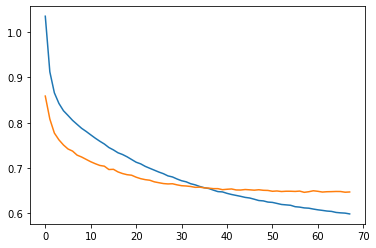

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.show()

In [ ]:
encoder_model = Model(encoder_input, encoder_state_h)

decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h]

decoder_output, decoder_state_h = decoder_lstm(decoder_input,
                                              initial_state = decoder_state_in_h)
decoder_output = decoder_dense(decoder_output)

decoder_model = Model([decoder_input] + decoder_state_in,
                     [decoder_output, decoder_state_h])

encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

In [ ]:
def respond(input_data, beta = 5):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, n_char))
    y_decoder[0][0][char_indices["\t"]] = 1
    
    respond_sentence = ""
    
    while True:
        y, h = decoder_model.predict([y_decoder, state_value])
        p_power = y[0][0] ** beta
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))
        next_char = indices_char[next_index]
        
        if (next_char == "\n" or len(respond_sentence) >= max_length_x):
            break
            
        respond_sentence += next_char
        y_decoder = np.zeros((1, 1, n_char))
        y_decoder[0][0][next_index] = 1
        
        state_value = h
        
    return respond_sentence

In [ ]:
for i in range(100):
    x_in= x_encoder[i:i+1]
    responce = respond(x_in)
    print("Input:", x_sentences[i])
    print("Responce:", responce)
    print()

Input: カムパネルラがてをあげました。
Responce: おまえはなんだか、いっっているのです。

Input: それからし、ごにんてをあげました。
Responce: それから、そのとき、こんどは、またさぶろうだっていいました。

Input: ジョバンニもてをあげようとして、いそいでそのままやめました。
Responce: するとカムパネルラが、それからあのいろいろなかやしいのです。

Input: たしかにあれがみんなほしだと、いつかざっしでよんだのでしたが、このごろはジョバンニはまるでまいにちきょうしつでもねむく、ほんをよむひまもよむほんもないので、なんだかどんなこともよくわからないというきもちがするのでした。
Responce: それはまたさぶろうは、そのまえにとんでいってしまいました。

Input: ところがせんせいははやくもそれをみつけたのでした。
Responce: そのとき、こんどは、あのまりにちょうどあしをかけて、いっしょうけんいのちに、いちろうのにいさんが、いちばんうしろのほうへいっていました。

Input: ジョバンニさん。
Responce: ああ、あ、たまはもうだいじょうぶです。

Input: あなたはわかっているのでしょうジョバンニはいきおいよくたちあがりましたが、たってみるともうはっきりとそれをこたえることができないのでした。
Responce: ジョバンニは、もういちぺんにかいてありました。

Input: ザネリがまえのせきからふりかえって、ジョバンニをみてくすっとわらいました。
Responce: ジョバンニは、もういちぺんにかいてありました。

Input: ジョバンニはもうどぎまぎしてまっあかになってしまいました。
Responce: そしてそのかわりにわかになって、そのとききょうしつのなかにはなして、いちろうのにいさんが、またさぶろうのところへいきました。

Input: せんせいがまたいいました。
Responce: おとうさんがいいました。

Input: おおきなぼうえんきょうでぎんがをよっくしらべるとぎんがはだいたいなんでしょうやっぱりほしだとジョバンニはおもいましたが、こんどもすぐにこたえることができませんでした。
Responce: それから、そのおとこは、またいっしょにいってしまいました。

I

In [ ]:
import pickle

with open('kana_chars.pickle', mode = 'rb') as f:
    chars_list = pickle.load(f)
print(chars_list)

['\t', '\n', 'A', 'C', 'D', 'E', 'H', 'I', 'L', 'N', 'O', 'R', 'S', 'T', 'U', 'W', '、', '。', '〇', 'ぁ', 'あ', 'ぃ', 'い', 'ぅ', 'う', 'ぇ', 'え', 'ぉ', 'お', 'か', 'が', 'き', 'ぎ', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'さ', 'ざ', 'し', 'じ', 'す', 'ず', 'せ', 'ぜ', 'そ', 'ぞ', 'た', 'だ', 'ち', 'ぢ', 'っ', 'つ', 'づ', 'て', 'で', 'と', 'ど', 'な', 'に', 'ぬ', 'ね', 'の', 'は', 'ば', 'ぱ', 'ひ', 'び', 'ぴ', 'ふ', 'ぶ', 'ぷ', 'へ', 'べ', 'ぺ', 'ほ', 'ぼ', 'ぽ', 'ま', 'み', 'む', 'め', 'も', 'ゃ', 'や', 'ゅ', 'ゆ', 'ょ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'ゎ', 'わ', 'ゐ', 'ゑ', 'を', 'ん', 'ァ', 'ア', 'ィ', 'イ', 'ゥ', 'ウ', 'ェ', 'エ', 'ォ', 'オ', 'カ', 'ガ', 'キ', 'ギ', 'ク', 'グ', 'ケ', 'ゲ', 'コ', 'ゴ', 'サ', 'ザ', 'シ', 'ジ', 'ス', 'ズ', 'セ', 'ゼ', 'ソ', 'ゾ', 'タ', 'ダ', 'チ', 'ヂ', 'ッ', 'ツ', 'ヅ', 'テ', 'デ', 'ト', 'ド', 'ナ', 'ニ', 'ヌ', 'ネ', 'ノ', 'ハ', 'バ', 'パ', 'ヒ', 'ビ', 'ピ', 'フ', 'ブ', 'プ', 'ヘ', 'ベ', 'ペ', 'ホ', 'ボ', 'ポ', 'マ', 'ミ', 'ム', 'メ', 'モ', 'ャ', 'ヤ', 'ュ', 'ユ', 'ョ', 'ヨ', 'ラ', 'リ', 'ル', 'レ', 'ロ', 'ヮ', 'ワ', 'ヰ', 'ヱ', 'ヲ', 'ン', 'ヴ', 'ー', '苹', '！', '？']


In [ ]:
import numpy as np

char_indices = {} #文字がキーでインデックスが値
for i, char in enumerate(chars_list):
    char_indices[char] = i
indices_char = {} #インデックスがキーで文字が値
for i, char in enumerate(chars_list):
    indices_char[i] = char
    
n_char = len(chars_list)
max_length_x = 128

def sentence_to_vector(sentence):
    vector = np.zeros((1, max_length_x, n_char), dtype = np.bool)
    for j, char in enumerate(sentence):
        vector[0][j][char_indices[char]] = 1
    return vector

In [ ]:
from keras.models import load_model

encoder_model=load_model('encoder_model.h5')
decoder_model=load_model('decoder_model.h5')

In [ ]:
def respond(input_data, beta = 5):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, n_char))
    y_decoder[0][0][char_indices["\t"]] = 1
    
    respond_sentence = ""
    
    while True:
        y, h = decoder_model.predict([y_decoder, state_value])
        p_power = y[0][0] ** beta
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))
        next_char = indices_char[next_index]
        
        if (next_char == "\n" or len(respond_sentence) >= max_length_x):
            break
            
        respond_sentence += next_char
        y_decoder = np.zeros((1, 1, n_char))
        y_decoder[0][0][next_index] = 1
        
        state_value = h
        
    return respond_sentence

In [ ]:
sentences = ["けんじさん、こんにちは。",
            "カムパネラってしってますか？",
            "ああ、おなかすいた。",
            "きょうはいいてんきですね。",
            "すきなたべものは、なんですか。",
            "きょうは、さんぽにいきました。",
            "パソコンかスマホは、つかったことありますか？"
            ]

for sentence in sentences:
    vector = sentence_to_vector(sentence)
    print("Input:", sentence)
    print("Response",respond(vector))
    print()

Input: けんじさん、こんにちは。
Response ぼくはこんなにこんなことをいいました。

Input: カムパネラってしってますか？
Response おまえはもうあんまりない。

Input: ああ、おなかすいた。
Response ああ、ああ、こんなことでもいいました。

Input: きょうはいいてんきですね。
Response おとうさんがでてきました。

Input: すきなたべものは、なんですか。
Response おとうさんがでていました。

Input: きょうは、さんぽにいきました。
Response みんなはいいました。

Input: パソコンかスマホは、つかったことありますか？
Response そしてそのおとこは、もうきょうしつのなかにはいってきました。



In [ ]:
response_a = "こんにちは。"
response_b = ""
for i in range(100):
    print("賢治A：", response_a)
    print()
    vector_a = sentence_to_vector(response_a)
    
    response_b = respond(vector_a)
    print("賢治B:", response_b)
    print()
    vector_b = sentence_to_vector(response_b)
    
    response_a = respond(vector_b)

賢治A： こんにちは。

賢治B: どうもありません。

賢治A： またさぶろうはいいました。

賢治B: またさぶろうはまたいいました。

賢治A： またさぶろうは、いちろうのにいさんがいいました。

賢治B: さぶろうはまたあたまをしていました。

賢治A： みんなはいちろうのにいさんが、いきなりまどのそとをみていました。

賢治B: さぶろうは、だまってしまいました。

賢治A： みんなはいちめんにして、それからもういっぱいにひきました。

賢治B: それからそれからあのはやしのなかでは、あのあかりのあたりは、あのしろいはなをみていました。

賢治A： それから、わたしはこのなかにはなして、なんだか。

賢治B: おまえはもういっっているよ。

賢治A： それからあたまをかけて、いっているんだ。

賢治B: おまえはもうあんまりかわをにげているようにおもいました。

賢治A： そしてそのおとこは、またさぶろうのおとうさんが、またさぶろうのおとうさんが、またさぶろうのかいのひをとって、いっしょうけんいのちにおいて、またさぶろうのおとうさんが、まるでおとうさんのおとうさんが、いままでもいいました。

賢治B: ジョバンニは、もういちぺんにさけびました。

賢治A： またさぶろうは、いちろうのにいさんが、いちろうのにいさんが、またさぶろうのかげのようなきがして、それからあわてていきました。

賢治B: さぶろうはそのおとこは、いちろうのにいさんが、いままでにいきました。

賢治A： みんなはそのとききしゃのしょうめんに、いちろうのかいのひがしたりして、それからそのなかのところへいきました。

賢治B: そして、そのうちには、あのたからは、あのいちばんのしたには、あのあかりをかけて、いきなり、かおをみていました。

賢治A： それはもういいました。

賢治B: おまえはもういちぺんにいいました。

賢治A： それから、そのつぎのにちは、うまいぞ。

賢治B: といいました。

賢治A： そしてそのかわりには、あのあかりは、おおきなこえで、またさぶろうのにんは、いっていたのです。

賢治B: そのとききょうしつのなかでは、あのまりのきのしたには、ああいのじょうにはしっているのでした。

賢治A： そのときは、はやくはしっていました。

賢治B: おとうさんは、いままでも